In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

# Helpers for sampling data from GP

In [2]:
def eq_covariance(inputs1,
                  inputs2,
                  scale,
                  cov_coeff,
                  noise_coeff):
    
    diff = inputs1[:, :, None] - inputs2[:, None, :]
    
    quad = (diff / (2 * scale ** 2)) ** 2
    
    exp_quad = cov_coeff ** 2 * np.exp(- quad)
    
    return exp_quad


def sample_dataset(batch_size,
                   num_train,
                   num_test,
                   scale,
                   cov_coeff,
                   noise_coeff,
                   as_tensor):
    
    x_train_test = np.random.uniform(low=-3., high=3., size=(batch_size, num_train + num_test,))

    cov_train_test = eq_covariance(x_train_test,
                                   x_train_test,
                                   scale,
                                   cov_coeff,
                                   noise_coeff)
    
    cov_train_test = cov_train_test + noise_coeff ** 2 * np.eye(cov_train_test.shape[-1])[None, :, :]
    
    zeros = np.zeros((cov_train_test.shape[1],))
    noise = np.random.multivariate_normal(zeros, np.diag(np.ones_like(zeros)), size=(batch_size,))
    chol_train_test = np.linalg.cholesky(cov_train_test)
    
    y_train_test = np.einsum('bij, bj -> bi', chol_train_test, noise)
    
    x_train = x_train_test[:, :num_train]
    x_test = x_train_test[:, num_train:]
    
    y_train = y_train_test[:, :num_train]
    y_test = y_train_test[:, num_train:]
    
    
    x_train, y_train, x_test, y_test = [torch.tensor(array).float() if as_tensor else array \
                                        for array in (x_train, y_train, x_test, y_test)]
    
    return (x_train, y_train), (x_test, y_test)


def gp_post_pred(train_inputs,
                 train_outputs,
                 pred_inputs,
                 scale,
                 cov_coeff,
                 noise_coeff):
    
    K = eq_covariance(train_inputs,
                      train_inputs,
                      scale,
                      cov_coeff,
                      noise_coeff)[0]
    
    K = K + noise_coeff ** 2 * np.eye(K.shape[-1])
    
    k_star = eq_covariance(pred_inputs,
                           train_inputs,
                           scale,
                           cov_coeff,
                           noise_coeff)[0]
    
    means = np.dot(k_star, np.linalg.solve(K, train_outputs[0]))
    
    K_inv_k_star = np.linalg.solve(K, k_star.T)
    stds = (cov_coeff - np.diag(np.einsum('ij, jk -> ik', k_star, K_inv_k_star)) + noise_coeff ** 2)
    
    return means, stds

# Sample and plot a few datapoints

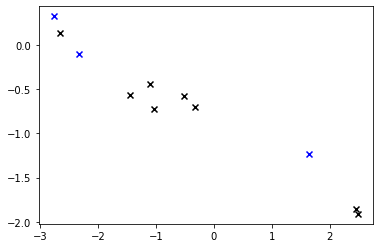

In [3]:
num_batches = 1
num_train = 8
num_test = 3
lengthscale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = False

train_data, test_data = sample_dataset(num_batches,
                                       num_train,
                                       num_test,
                                       lengthscale,
                                       cov_coeff,
                                       noise_coeff,
                                       as_tensor)

plt.scatter(train_data[0][0], train_data[1][0], marker='x', color='black')
plt.scatter(test_data[0][0], test_data[1][0], marker='x', color='blue')

# plt.xlim([-4, 4])
# plt.ylim([-2, 2])
plt.show()

# CNP definition

In [4]:
class FeedforwardNetwork(nn.Module):
    
    
    def __init__(self,
                 input_dim,
                 output_dim,
                 nums_hidden,
                 nonlinearity):
        
        super().__init__()
        
        sizes = [input_dim] + nums_hidden + [output_dim]
        sizes = [(s1, s2) for s1, s2 in zip(sizes[:-1], sizes[1:])]
        
        self.linear = [nn.Linear(s1, s2, bias=True) for s1, s2 in sizes]
        self.linear = nn.ModuleList(self.linear)
        
        self.nonlinearity = getattr(nn, nonlinearity)()
        
    
    def forward(self, tensor):
        
        for linear in self.linear[:-1]:
            
            tensor = linear(tensor)
            tensor = self.nonlinearity(tensor)
            
        tensor = self.linear[-1](tensor)
        
        return tensor
    
    
class ConditionalNeuralProcess(nn.Module):
    
    def __init__(self,
                 discriminator,
                 encoder):
        
        
        super().__init__()
        
        self.discriminator = discriminator
        self.encoder = encoder
        
        self.normal = torch.distributions.Normal
        
        
    def forward(self,
                context_inputs,
                context_outputs,
                target_inputs):
        
        context_inputs = context_inputs.unsqueeze(dim=-1)
        context_outputs = context_outputs.unsqueeze(dim=-1)
        target_inputs = target_inputs.unsqueeze(dim=-1)
        
        context = torch.cat([context_inputs, context_outputs], dim=-1)
        
        theta = self.encoder(context)
        theta = torch.mean(theta, dim=1)[:, None, :]
        theta = theta.repeat(1, target_inputs.shape[1], 1)
        
        tensor = torch.cat([target_inputs, theta], dim=-1)
        
        tensor = self.discriminator(tensor)
        tensor = torch.reshape(tensor, tensor.shape[:2] + (-1, 2))
        
        mean, log_stdev = tensor[:, :, :, 0], tensor[:, :, :, 1]
        
        return mean, log_stdev
    
    
    def _loss(self,
              context_inputs,
              context_outputs,
              target_inputs,
              target_outputs):
        
        target_outputs = target_outputs.unsqueeze(dim=-1)
        
        mean, log_stdev = self.forward(context_inputs,
                                       context_outputs,
                                       target_inputs)
        
        stdev = torch.exp(log_stdev)
        
        cond_dist = self.normal(loc=mean, scale=stdev)
        
        log_prob = cond_dist.log_prob(target_outputs)
        
        log_prob = torch.mean(log_prob, dim=0)
        log_prob = torch.sum(log_prob)
        
        return - log_prob
    
    
    def loss(self,
             inputs,
             outputs,
             num_samples):
        
        loss = 0
        
        for i in range(num_samples):
            
            N = np.random.choice(np.arange(1, inputs.shape[1]))
            
            context_inputs = inputs[:, :N]
            context_outputs = outputs[:, :N]
            target_inputs = inputs[:, N:]
            target_outputs = outputs[:, N:]
            
            loss = loss + self._loss(context_inputs,
                                     context_outputs,
                                     target_inputs,
                                     target_outputs)
        
        loss = loss / num_samples
        
        return loss

# Helper to visualise during training

In [5]:
def plot_sample_and_predictions(conditional_neural_process,
                                num_train,
                                num_test,
                                scale,
                                cov_coeff,
                                noise_coeff,
                                step,
                                plot_test_data=False):

    train_data, test_data = sample_dataset(batch_size=1,
                                           num_train=num_train,
                                           num_test=num_test,
                                           scale=scale,
                                           cov_coeff=cov_coeff,
                                           noise_coeff=noise_coeff,
                                           as_tensor=True)

    context_inputs, context_outputs = train_data
    target_inputs = torch.linspace(-6, 6, 100)[None, :]
    
    pred_mean, pred_log_stdev = conditional_neural_process.forward(context_inputs,
                                                                   context_outputs,
                                                                   target_inputs)
    
    gp_means, gp_stds = gp_post_pred(train_data[0],
                                     train_data[1],
                                     target_inputs,
                                     scale,
                                     cov_coeff,
                                     noise_coeff)
    
    target_inputs = target_inputs.squeeze().detach().numpy()
    pred_mean = pred_mean.squeeze().detach().numpy()
    pred_stdev = torch.exp(pred_log_stdev).squeeze().detach().numpy()
    
    plt.plot(target_inputs, gp_means, color='blue', zorder=1)
    plt.fill_between(target_inputs, gp_means - gp_stds, gp_means + gp_stds, color='blue', alpha=0.3, zorder=1)
    
    plt.scatter(train_data[0], train_data[1], s=100, marker='x', color='black', label='Context (observed)')
    plt.plot(target_inputs, pred_mean, color='black')
    plt.fill_between(target_inputs, pred_mean - pred_stdev, pred_mean + pred_stdev, color='gray', alpha=0.3)
    
    if plot_test_data:
        plt.scatter(test_data[0], test_data[1], marker='x', color='red', label='Target (unobserved)', alpha=0.2, zorder=1)

    plt.xlim([-6, 6])
    plt.ylim([-3, 3])
    plt.legend(loc='lower right')
    plt.title(f'Step {step}', fontsize=16)
    
    plt.show()

# All aboard the training train choooo choooo!!!

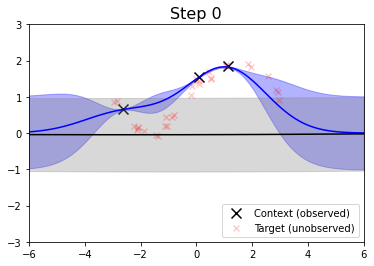

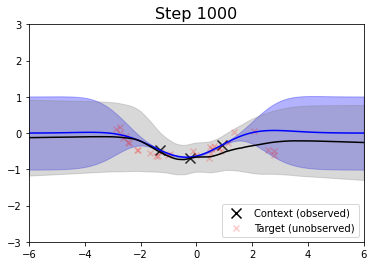

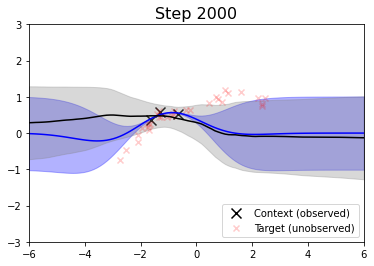

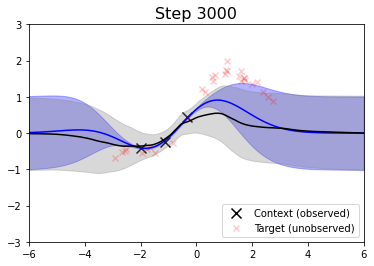

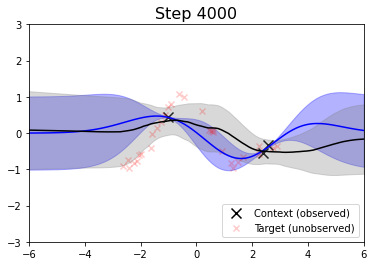

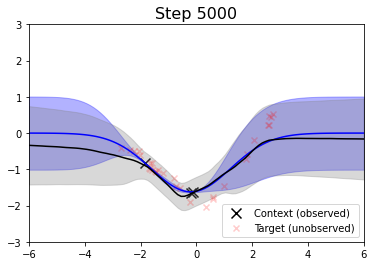

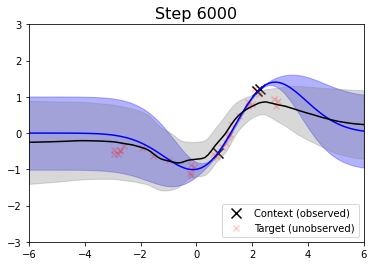

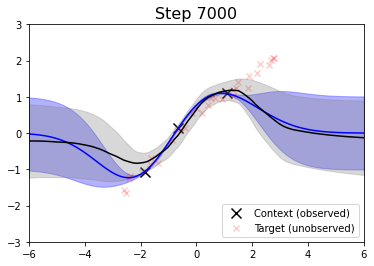

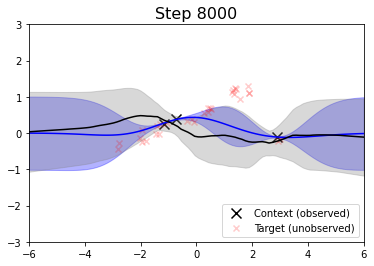

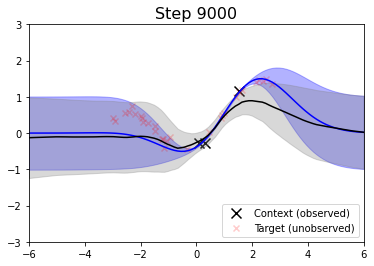

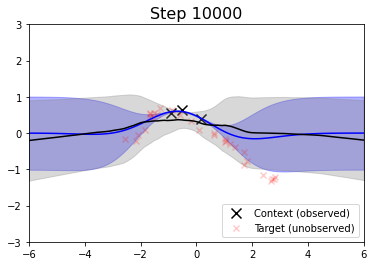

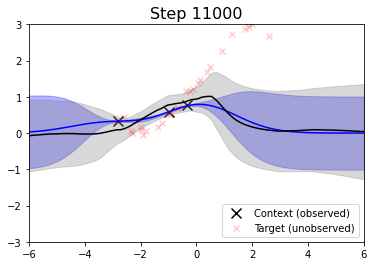

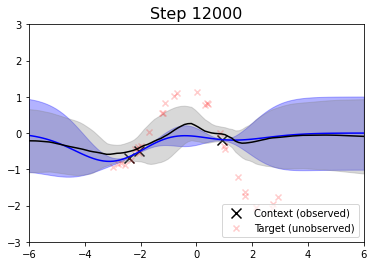

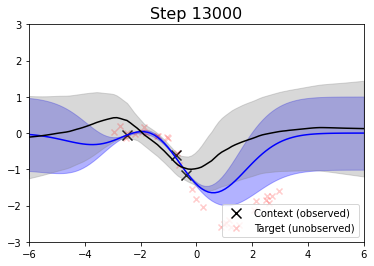

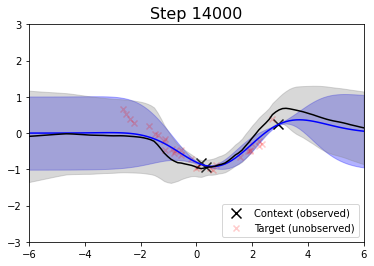

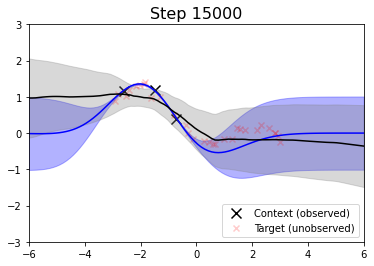

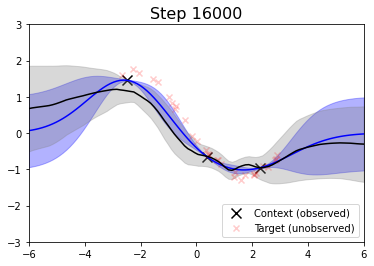

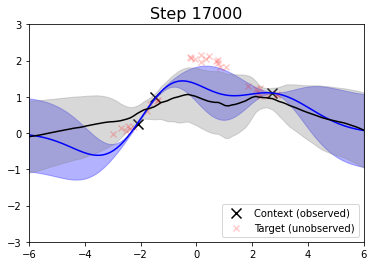

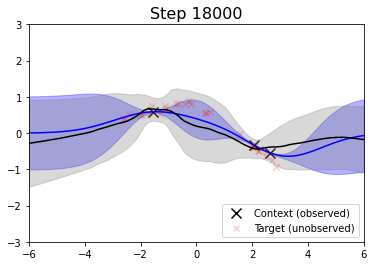

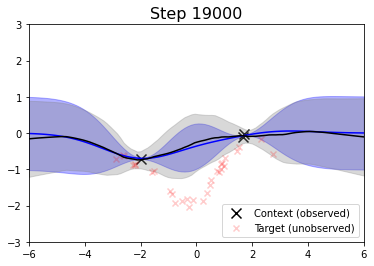

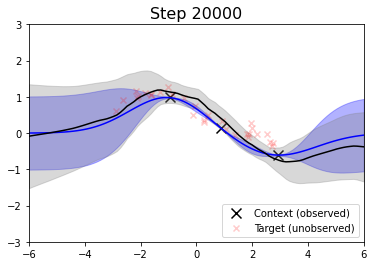

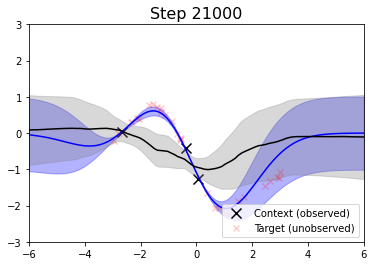

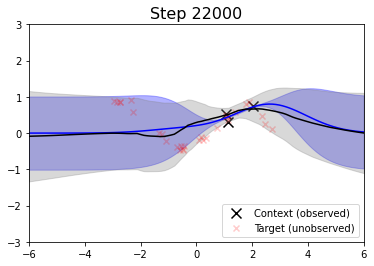

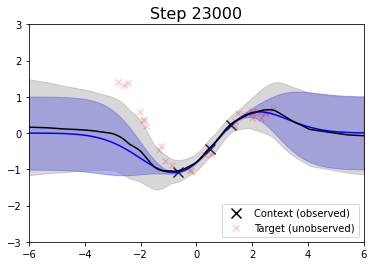

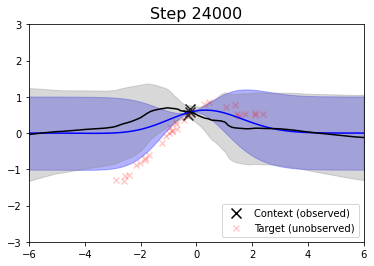

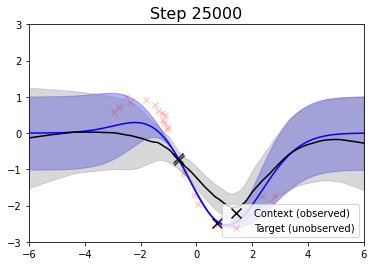

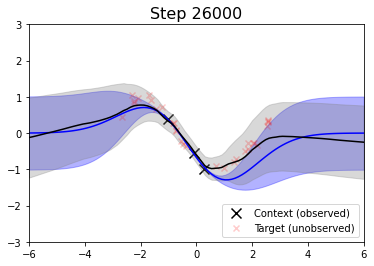

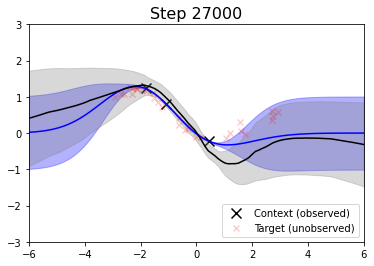

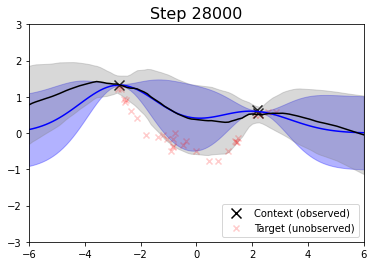

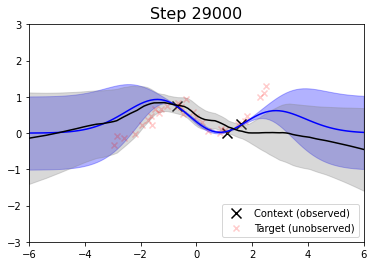

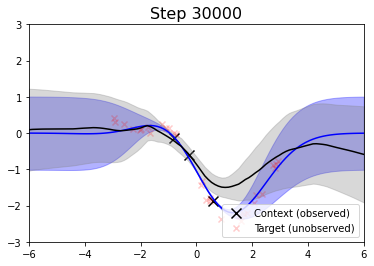

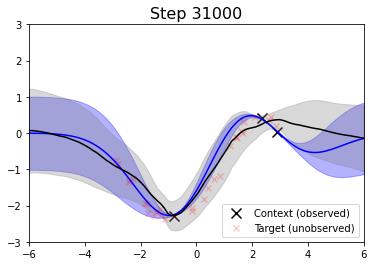

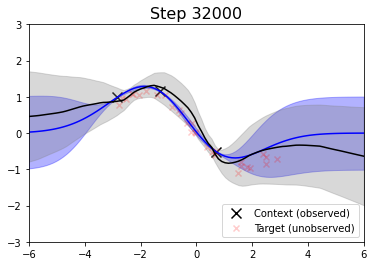

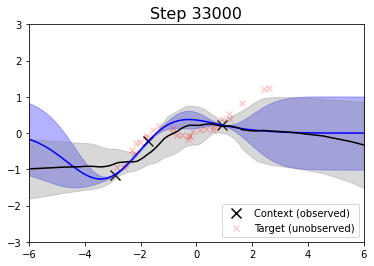

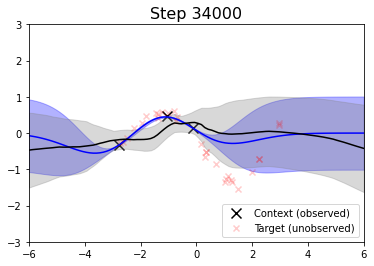

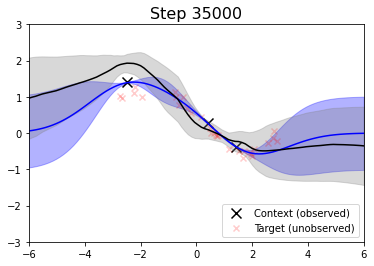

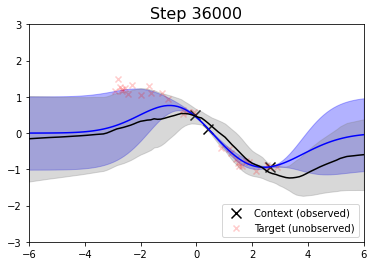

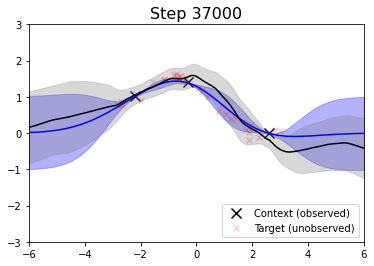

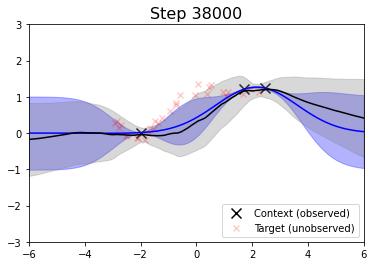

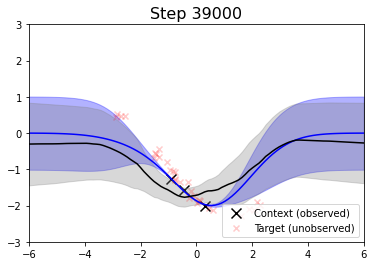

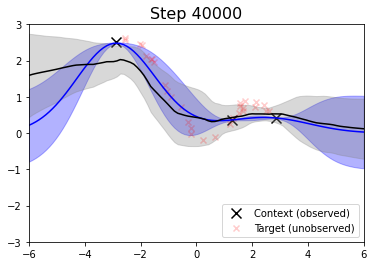

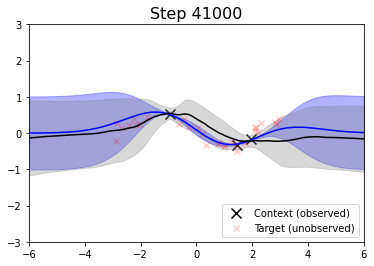

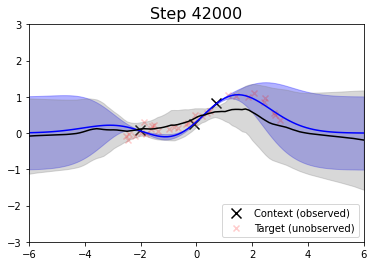

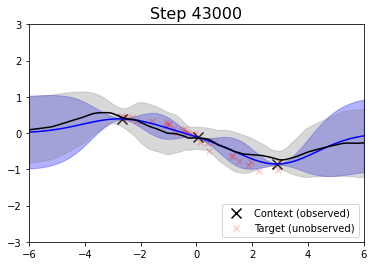

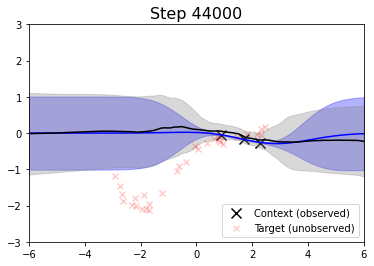

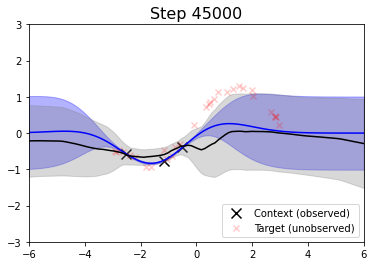

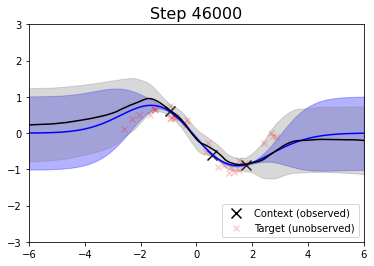

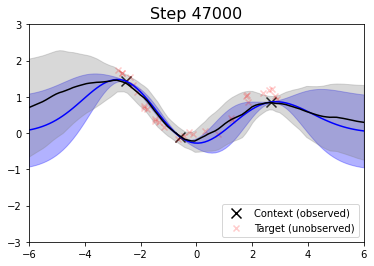

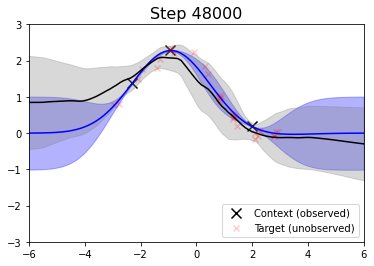

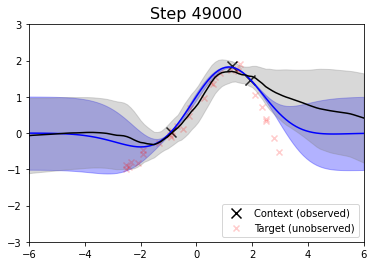

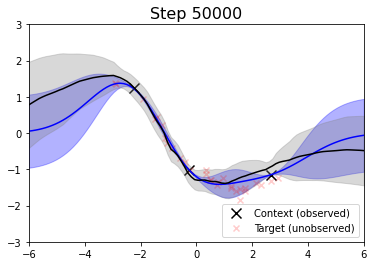

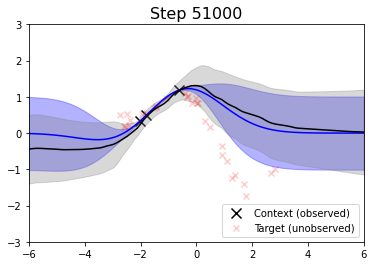

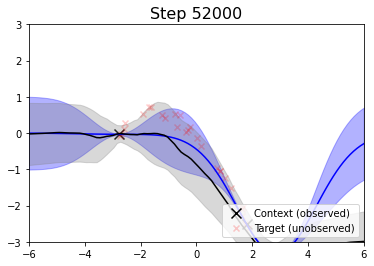

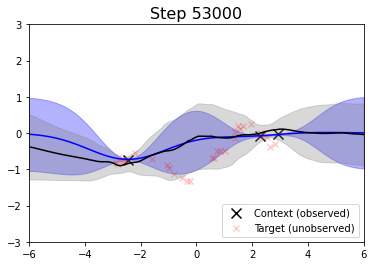

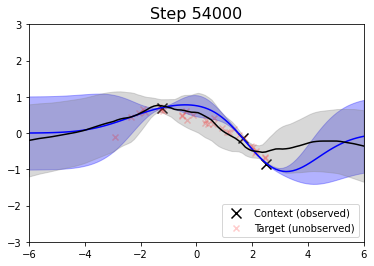

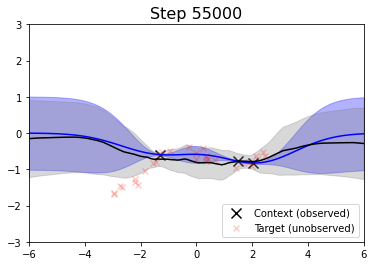

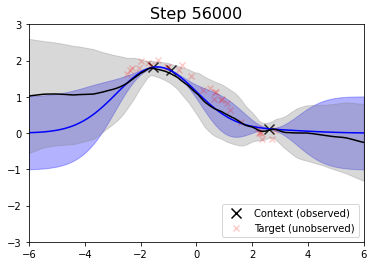

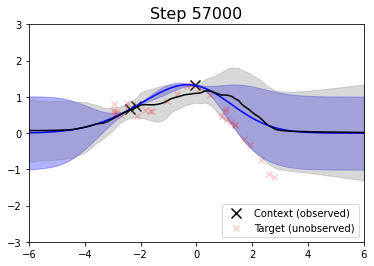

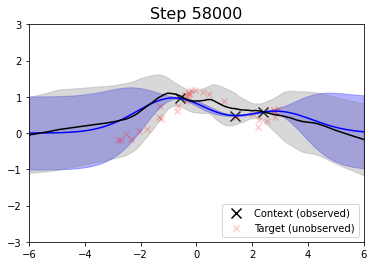

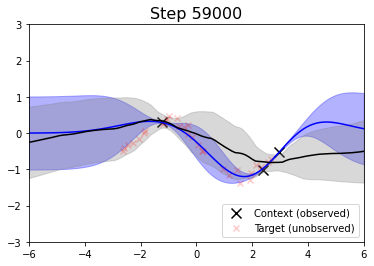

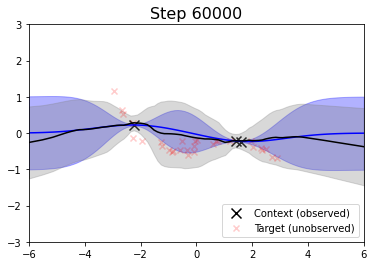

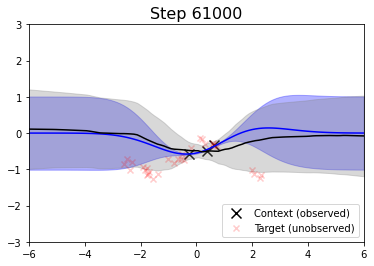

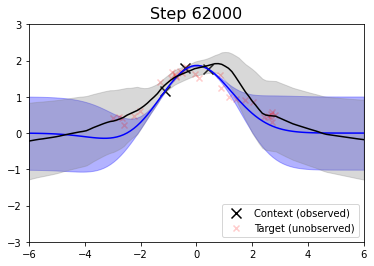

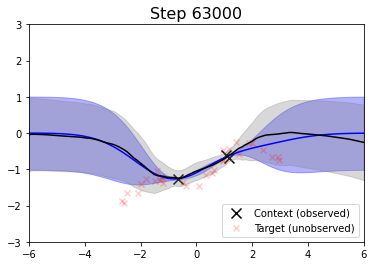

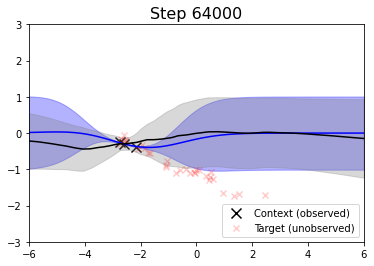

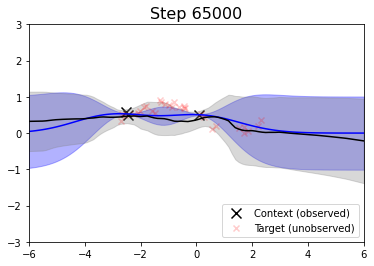

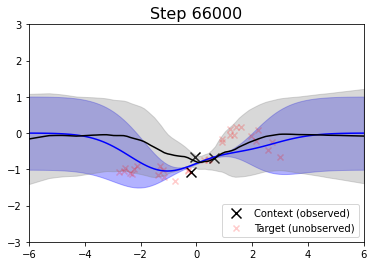

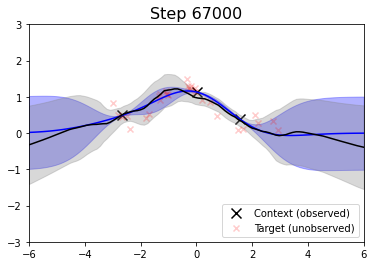

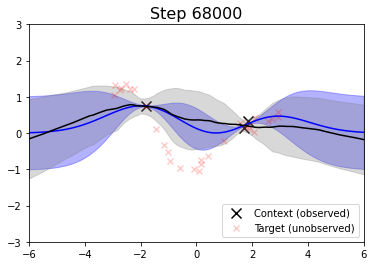

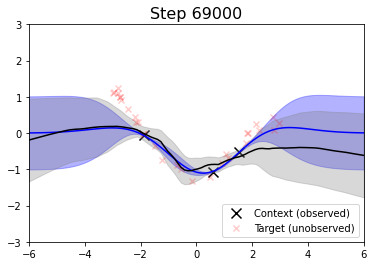

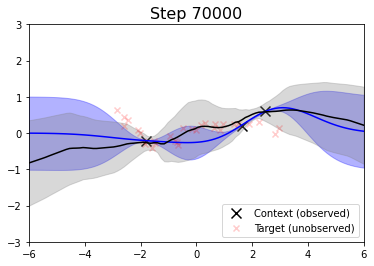

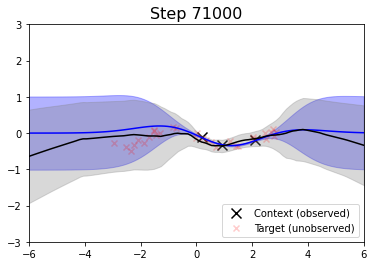

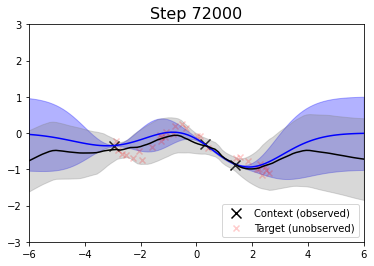

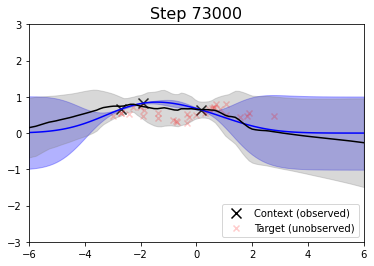

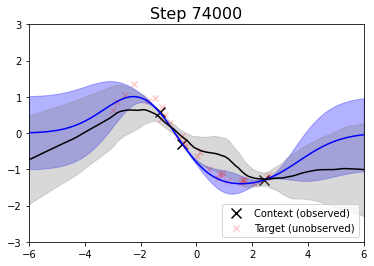

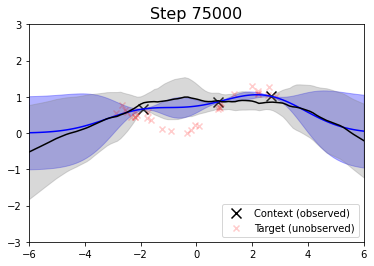

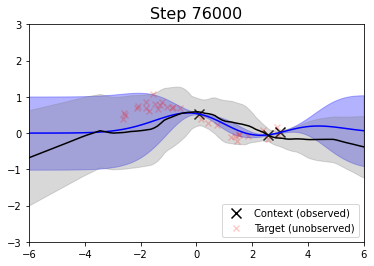

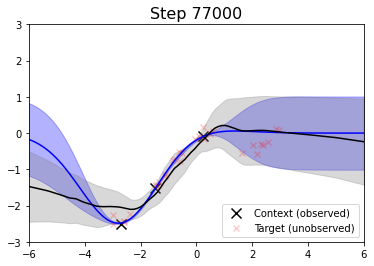

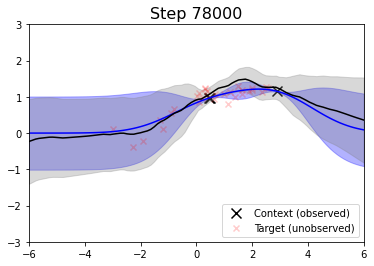

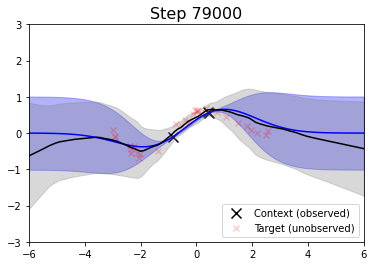

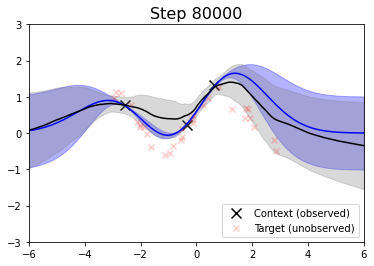

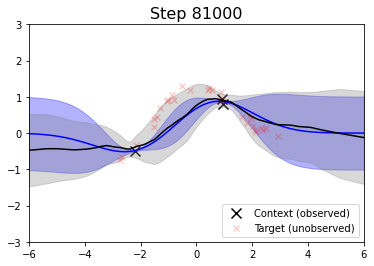

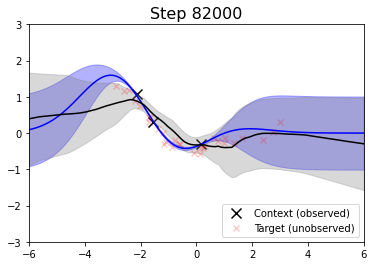

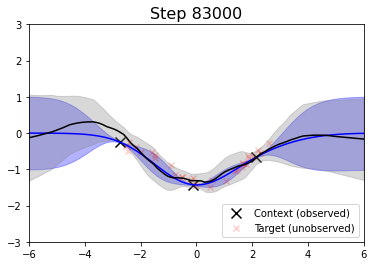

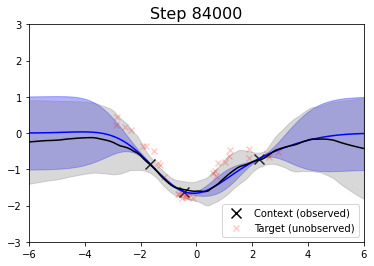

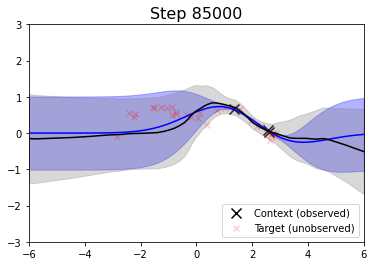

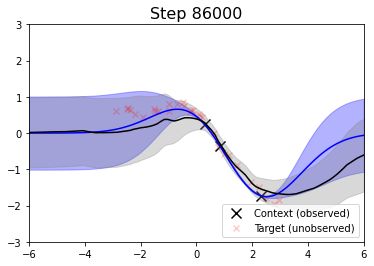

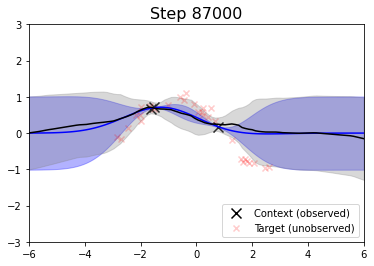

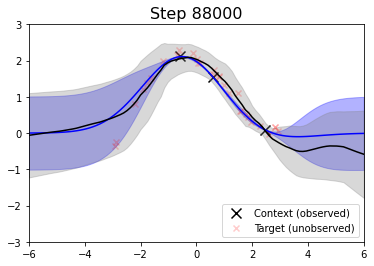

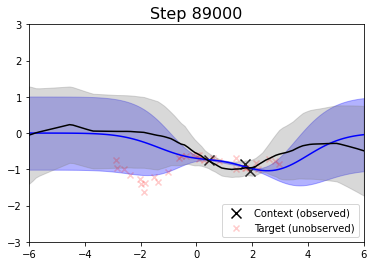

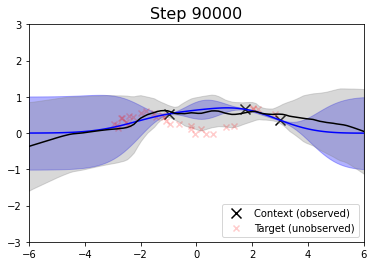

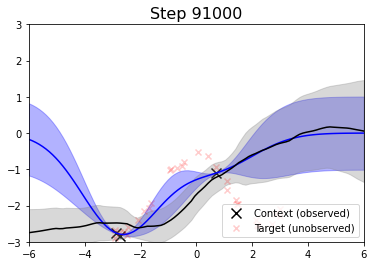

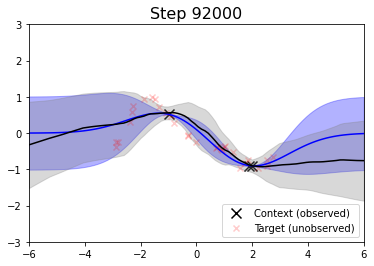

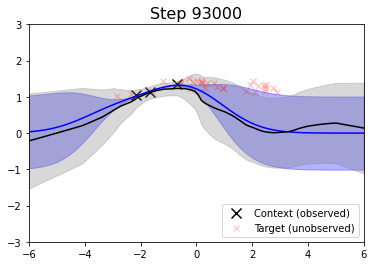

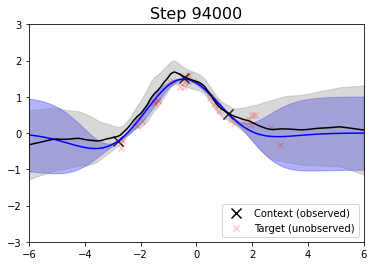

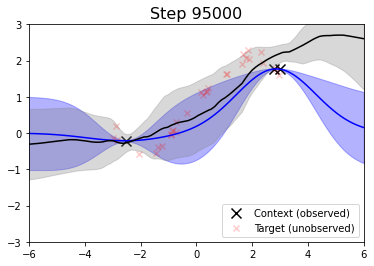

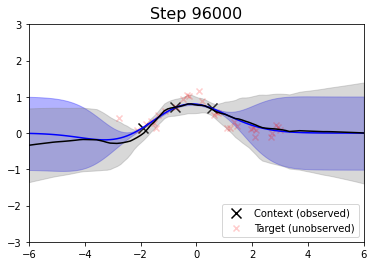

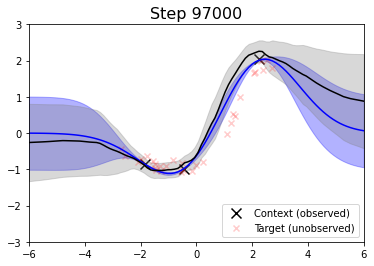

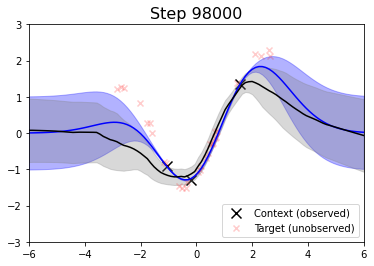

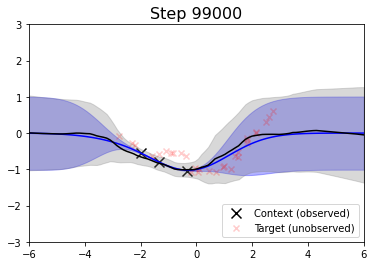

In [6]:
# Dataset parameters
batch_size = 20
num_train = 6
num_test = 5
scale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True

# Training parameters and optimizer
num_train_steps = int(1e5)
lr = 1e-3

discriminator = FeedforwardNetwork(input_dim=129,
                                   output_dim=2,
                                   nums_hidden=[128, 128, 128, 128],
                                   nonlinearity='ReLU')

encoder = FeedforwardNetwork(input_dim=2,
                             output_dim=128,
                             nums_hidden=[128, 128],
                             nonlinearity='ReLU')

conditional_neural_process = ConditionalNeuralProcess(discriminator=discriminator,
                                                      encoder=encoder)

optimizer = torch.optim.Adam(conditional_neural_process.parameters(), lr=lr)

losses = []

for i in range(num_train_steps):
    
    train_data, test_data = sample_dataset(batch_size,
                                           num_train,
                                           num_test,
                                           scale,
                                           cov_coeff,
                                           noise_coeff,
                                           as_tensor)
    
    inputs, outputs = train_data
    
    loss = conditional_neural_process.loss(inputs, outputs, num_samples=1)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 1e3 == 0:
        
        plot_sample_and_predictions(conditional_neural_process,
                                    num_train=3,
                                    num_test=30,
                                    scale=scale,
                                    cov_coeff=cov_coeff,
                                    noise_coeff=noise_coeff,
                                    step=i,
                                    plot_test_data=True)